Loading and Merging

In [1]:
!pip install pandas numpy seaborn matplotlib scikit-learn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

In [3]:
easyshare = pd.read_stata('data/sharewX_rel8-0-0_easySHARE_stata/easySHARE_rel8-0-0.dta')

illness_before = pd.read_stata("data/SHARE-ENV - Exposure to Environmental Hazards/illness_before_module_v01.dta")
illness_during = pd.read_stata("data/SHARE-ENV - Exposure to Environmental Hazards/illness_during_module_v01.dta")
job = pd.read_stata("data/SHARE-ENV - Exposure to Environmental Hazards/job_module_v01.dta")
life = pd.read_stata("data/SHARE-ENV - Exposure to Environmental Hazards/life_module_v01.dta")
young_age = pd.read_stata("data/SHARE-ENV - Exposure to Environmental Hazards/young_age_module_v01.dta")
#yearly = pd.read_stata("data/SHARE-ENV - Exposure to Environmental Hazards/yearly_module_v01.dta")
# individual_year = pd.read_stata(\"data/SHARE-ENV - Exposure to Environmental Hazards/individual_year_panel_v01.dta\")  NB times out, I ran it for 2+hrs,
#merged.to_pickle(\"data/df_merged.pkl\"

In [4]:
df = pd.merge(easyshare, life, on=['mergeid', 'wave'], how='left')
df = pd.merge(df, job, on=['mergeid'], how='left')

In [5]:
df_sorted = df.sort_values(by=['mergeid', 'wave'], ascending=[True, False])
df_most_recent_wave_per_mergeid = df_sorted.drop_duplicates(subset='mergeid', keep='first')

In [6]:
df_most_recent_wave_per_mergeid

,mergeid,hhid,coupleid,wave,wavepart,int_version,int_year,int_month,country,country_mod,...,yjob_tn_neg5_w,yjob_tx_25_27p5_mean,yjob_tx_25_27p5_median,yjob_tx_25_27p5_w,yjob_tx_27p5_30_mean,yjob_tx_27p5_30_median,yjob_tx_27p5_30_w,yjob_tx_g30_mean,yjob_tx_g30_median,yjob_tx_g30_w
1,AT-000327-01,AT-000327-A,AT-000327-01-02,2,12,1. Longitudinal questionnaire,2007,3. March,11. Austria,40. Austria,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT-000327-02,AT-000327-A,AT-000327-01-02,2,12,1. Longitudinal questionnaire,2007,3. March,11. Austria,40. Austria,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AT-000674-01,AT-000674-A,,6,456,1. Longitudinal questionnaire,2015,6. June,11. Austria,40. Austria,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,AT-001215-01,AT-001215-A,,8,45678,1. Longitudinal questionnaire,2020,1. January,11. Austria,40. Austria,...,961.412781,359.674042,340.5,413.609985,184.639114,177.5,215.542038,86.916176,86.5,92.543343
16,AT-001492-01,AT-001492-A,AT-001492-01-02,8,45678,1. Longitudinal questionnaire,2020,2. February,11. Austria,40. Austria,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412103,SK-995042-01,SK-995042-A,SK-995042-01-02,8,78,0. Baseline questionnaire,2019,12. December,63. Slovakia,703. Slovakia,...,1212.905640,1161.859985,1173.0,1172.955933,818.739990,846.0,840.694641,664.140015,692.0,691.040222
412105,SK-995042-02,SK-995042-A,SK-995042-01-02,8,78,0. Baseline questionnaire,2019,12. December,63. Slovakia,703. Slovakia,...,1378.774780,1359.319946,1374.0,1373.268677,951.159973,977.0,973.190430,822.940002,858.5,855.598572
412107,SK-996004-01,SK-996004-A,,8,78,0. Baseline questionnaire,2020,2. February,63. Slovakia,703. Slovakia,...,1557.454102,604.861084,615.0,664.630554,344.666656,340.5,389.068481,190.055557,157.5,233.034607
412108,SK-999958-01,SK-999958-A,SK-999958-01-02,7,7,0. Baseline questionnaire,2017,8. August,63. Slovakia,703. Slovakia,...,1035.219971,1049.370361,1065.0,1074.776978,682.814819,693.0,715.298401,489.703705,502.0,551.870544


Preprocessing

In [7]:
df_relevant = df_most_recent_wave_per_mergeid[df_most_recent_wave_per_mergeid.columns.drop(list(df.filter(regex='^euro')))]
df_relevant = df_relevant[df_relevant.columns.drop(list(df_relevant.filter(regex='^dn')))]
non_predictive_vars = [
    'mergeid',    # Used for merging records, no predictive power
    'hhid',       # Household identifier for tracking or grouping data
    'coupleid',   # Links records of individuals within a household
    'int_version',# Version of the questionnaire or interview format
    'int_year',   # Year the interview was conducted, structural rather than predictive
    'int_month',  # Month the interview was conducted, similar to int_year
    'country',    # Country code, used for stratification or adjustments
    'country_mod', # Modified country code, typically for data manipulation
    'wavepart'   # Wave part, used for stratification or adjustments
]
df_relevant = df_relevant[df_relevant.columns.drop(non_predictive_vars)]

In [8]:
df_relevant

,wave,language,female,age,birth_country,citizenship,iv009_mod,q34_re,isced1997_r,eduyears_mod,...,yjob_tn_neg5_w,yjob_tx_25_27p5_mean,yjob_tx_25_27p5_median,yjob_tx_25_27p5_w,yjob_tx_27p5_30_mean,yjob_tx_27p5_30_median,yjob_tx_27p5_30_w,yjob_tx_g30_mean,yjob_tx_g30_median,yjob_tx_g30_w
1,2,11. German (at),0. male,54.700001,40. Austria,40. Austrian,5. A rural area or village,-13. not asked in this wave,3. ISCED-97 code 3,-3. implausible value/suspected wrong,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,11. German (at),1. female,51.700001,40. Austria,40. Austrian,5. A rural area or village,-13. not asked in this wave,3. ISCED-97 code 3,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,11. German (at),1. female,63.299999,40. Austria,40. Austrian,-9. filtered: interview not at home,-13. not asked in this wave,5. ISCED-97 code 5,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,8,11. German (at),1. female,80.800003,528. Netherlands,528. Dutch (Netherlands),-9. filtered: interview not at home,-13. not asked in this wave,5. ISCED-97 code 5,15.0,...,961.412781,359.674042,340.5,413.609985,184.639114,177.5,215.542038,86.916176,86.5,92.543343
16,8,11. German (at),1. female,68.0,40. Austria,40. Austrian,2. The suburbs or outskirts of a big city,-13. not asked in this wave,3. ISCED-97 code 3,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412103,8,63. Slovakian,1. female,61.799999,703. Slovakia,703. Slovakian,3. A large town,-13. not asked in this wave,3. ISCED-97 code 3,-15. no information,...,1212.905640,1161.859985,1173.0,1172.955933,818.739990,846.0,840.694641,664.140015,692.0,691.040222
412105,8,63. Slovakian,0. male,64.599998,703. Slovakia,703. Slovakian,3. A large town,-13. not asked in this wave,3. ISCED-97 code 3,-15. no information,...,1378.774780,1359.319946,1374.0,1373.268677,951.159973,977.0,973.190430,822.940002,858.5,855.598572
412107,8,63. Slovakian,1. female,58.299999,703. Slovakia,703. Slovakian,4. A small town,-13. not asked in this wave,3. ISCED-97 code 3,13.0,...,1557.454102,604.861084,615.0,664.630554,344.666656,340.5,389.068481,190.055557,157.5,233.034607
412108,7,63. Slovakian,0. male,71.199997,703. Slovakia,703. Slovakian,2. The suburbs or outskirts of a big city,-13. not asked in this wave,3. ISCED-97 code 3,11.0,...,1035.219971,1049.370361,1065.0,1074.776978,682.814819,693.0,715.298401,489.703705,502.0,551.870544


In [9]:
def replace_dash_with_na(df_relevant):
    for column in df_relevant.columns:
        if df_relevant[column].dtype == 'category':
            # Replace entries containing '-' with NA
            df_relevant[column] = df[column].apply(lambda x: pd.NA if '-' in str(x) else x)
    return df_relevant

df_relevant = replace_dash_with_na(df_relevant)

In [10]:
na_counts = df_relevant.isna().sum()

na_counts_sorted = na_counts.sort_values(ascending=False)

na_counts_sorted

bmi2           140125
sp009_3_mod    138270
books_age10    137092
sp003_3_mod    137076
q34_re         136641
                ...  
partnerinhh         0
hhsize              0
language            0
thinc_m             0
wave                0
Length: 416, dtype: int64

In [11]:
for column in df_relevant.columns:
    if df_relevant[column].dtype == object:  # Check if the column data type is object
        # Try converting the column to numeric
        converted_column = pd.to_numeric(df_relevant[column], errors='coerce')
        # Check if the conversion did not introduce any new NaNs (i.e., all NaNs in the original are NaNs in the converted)
        if converted_column.notna().equals(df_relevant[column].notna()):
            df_relevant[column] = converted_column

df_relevant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140125 entries, 1 to 412109
Columns: 416 entries, wave to yjob_tx_g30_w
dtypes: category(7), float32(309), float64(50), int8(1), object(49)
memory usage: 273.2+ MB


In [12]:
columns_to_drop = na_counts[na_counts > 20000].index


df_dropped = df_relevant.drop(columns=columns_to_drop)

shape_of_dataframe_full = df_relevant.shape
shape_of_dataframe_dropped = df_dropped.shape

print(f"No. of samples: {shape_of_dataframe_full[0]}")
print(f"No. of columns (full): {shape_of_dataframe_full[1]}")
print(f"No. of columns (dropped): {shape_of_dataframe_dropped[1]}")

columns_to_drop

No. of samples: 140125
No. of columns (full): 416
No. of columns (dropped): 32


Index(['q34_re', 'isced1997_r', 'int_partner', 'age_partner', 'gender_partner',
       'siblings_alive', 'ch001_', 'ch021_mod', 'ch007_hh', 'ch007_km',
       ...
       'yjob_tn_neg5_w', 'yjob_tx_25_27p5_mean', 'yjob_tx_25_27p5_median',
       'yjob_tx_25_27p5_w', 'yjob_tx_27p5_30_mean', 'yjob_tx_27p5_30_median',
       'yjob_tx_27p5_30_w', 'yjob_tx_g30_mean', 'yjob_tx_g30_median',
       'yjob_tx_g30_w'],
      dtype='object', length=384)

In [13]:
na_after_dr = df_dropped.isna().sum().sort_values(ascending=False)

In [14]:
na_after_dr

maxgrip          18766
eduyears_mod     17840
iv009_mod        13522
recall_1         12337
recall_2         12257
bmi              11766
co007_           10559
father_alive     10501
mother_alive     10032
hc029_            8736
hc002_mod         8335
finemotor         7109
mobilityind       7109
grossmotor        7109
adla              6929
iadla             6929
iadlza            6929
adlwa             6929
hc012_            6834
lgmuscle          6785
chronic_mod       6716
mar_stat          6606
birth_country     1696
citizenship       1554
sphus             1020
age                 23
wave                 0
language             0
partnerinhh          0
hhsize               0
female               0
thinc_m              0
dtype: int64

In [15]:
shape_of_df_dropped = df_dropped.shape
print(f"The DataFrame has {shape_of_df_dropped[0]} rows and {shape_of_df_dropped[1]} columns.")
columns_in_df_dropped = df_dropped.columns.tolist()

print("Columns in df_dropped:")
print(columns_in_df_dropped)

The DataFrame has 140125 rows and 32 columns.
Columns in df_dropped:
['wave', 'language', 'female', 'age', 'birth_country', 'citizenship', 'iv009_mod', 'eduyears_mod', 'mar_stat', 'hhsize', 'partnerinhh', 'mother_alive', 'father_alive', 'sphus', 'chronic_mod', 'hc002_mod', 'hc012_', 'hc029_', 'maxgrip', 'adlwa', 'adla', 'iadla', 'iadlza', 'mobilityind', 'lgmuscle', 'grossmotor', 'finemotor', 'recall_1', 'recall_2', 'bmi', 'co007_', 'thinc_m']



EDA label variable

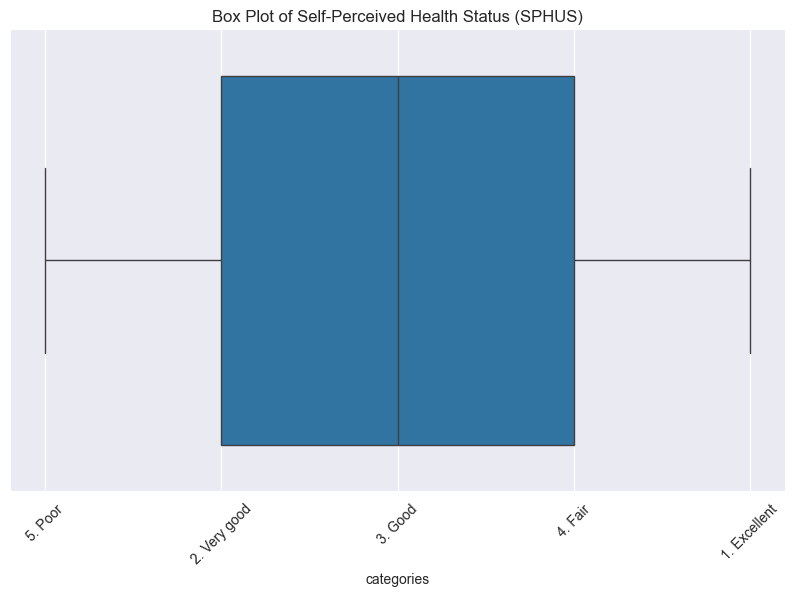

In [16]:
# box plot - doesn't make sense to do boxplot??
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_dropped['sphus'])
plt.title('Box Plot of Self-Perceived Health Status (SPHUS)')
plt.xlabel('categories')
plt.xticks(rotation=45)
plt.show()

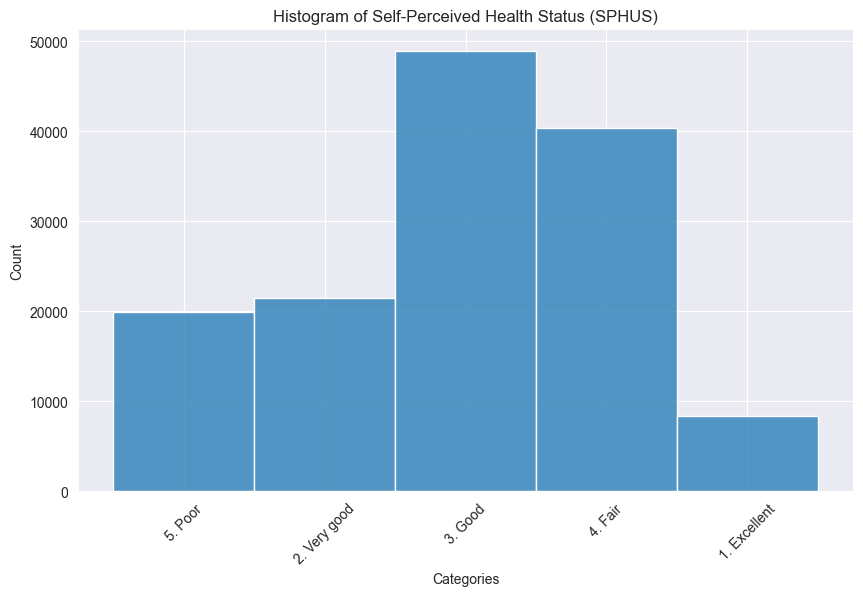

In [17]:
# histo
plt.figure(figsize=(10, 6))
sns.histplot(df_dropped['sphus'], discrete=True)
plt.title('Histogram of Self-Perceived Health Status (SPHUS)')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.show()

Grouped Feature Selection

In [18]:
variable_names = df_relevant.columns.tolist()

# Initialize lists for each category
temperature_vars = []
radiation_vars = []
precipitation_vars = []
pollution_vars = {'PM2.5': [], 'PM10': [], 'NO2': [], 'O3': []}
flood_vars = []
heating_cooling_vars = []  # For Heating Degree Days (HDD) and Cooling Degree Days (CDD)

for var in variable_names:
    # Temperature variables
    if 'tn_' in var or 'tg_' in var or 'tx_' in var:
        temperature_vars.append(var)
    
    # Radiation variables
    elif 'radiation' in var:
        radiation_vars.append(var)
    
    # Precipitation variables
    elif 'prec' in var:
        precipitation_vars.append(var)
    
    # Pollution variables
    elif 'pm2p5' in var or 'conc_pm2p5' in var:
        pollution_vars['PM2.5'].append(var)
    elif 'pm10' in var or 'conc_pm10' in var:
        pollution_vars['PM10'].append(var)
    elif 'no2' in var or 'conc_no2' in var:
        pollution_vars['NO2'].append(var)
    elif 'o3' in var or 'conc_o3' in var:
        pollution_vars['O3'].append(var)
    
    # Flood variables
    elif 'fl_' in var:
        flood_vars.append(var)
    
    # Heating and Cooling Degree Days
    elif 'HDD' in var or 'CDD' in var:
        heating_cooling_vars.append(var)

In [19]:
feature_groups = {
    'temperature': temperature_vars,
    'radiation': radiation_vars,
    'precipitation': precipitation_vars,
    'pollution_PM2.5': pollution_vars['PM2.5'],
    'pollution_PM10': pollution_vars['PM10'],
    'pollution_NO2': pollution_vars['NO2'],
    'pollution_O3': pollution_vars['O3'],
    'floods': flood_vars,
    'heating_cooling': heating_cooling_vars
}

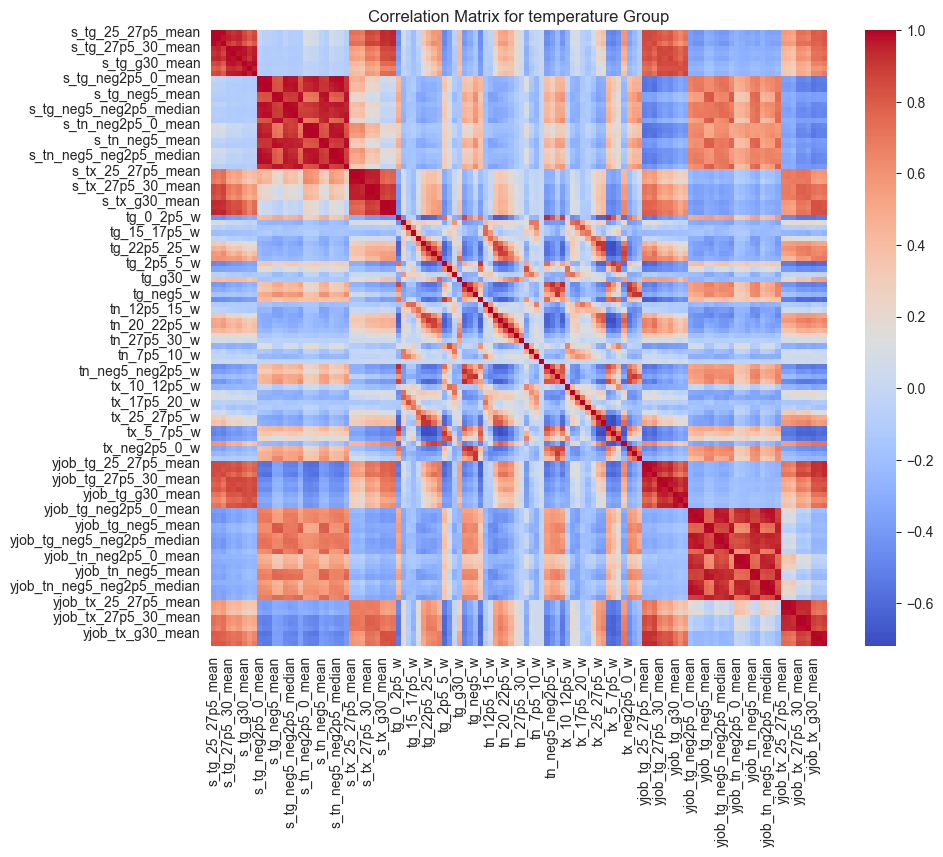

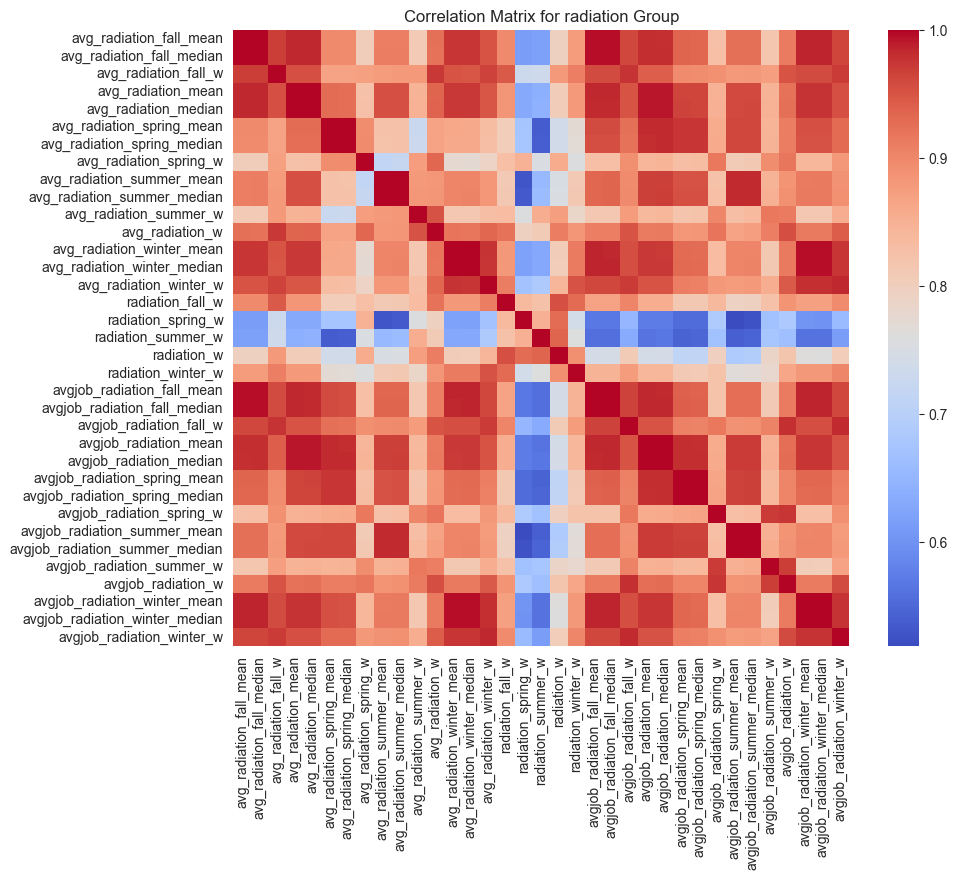

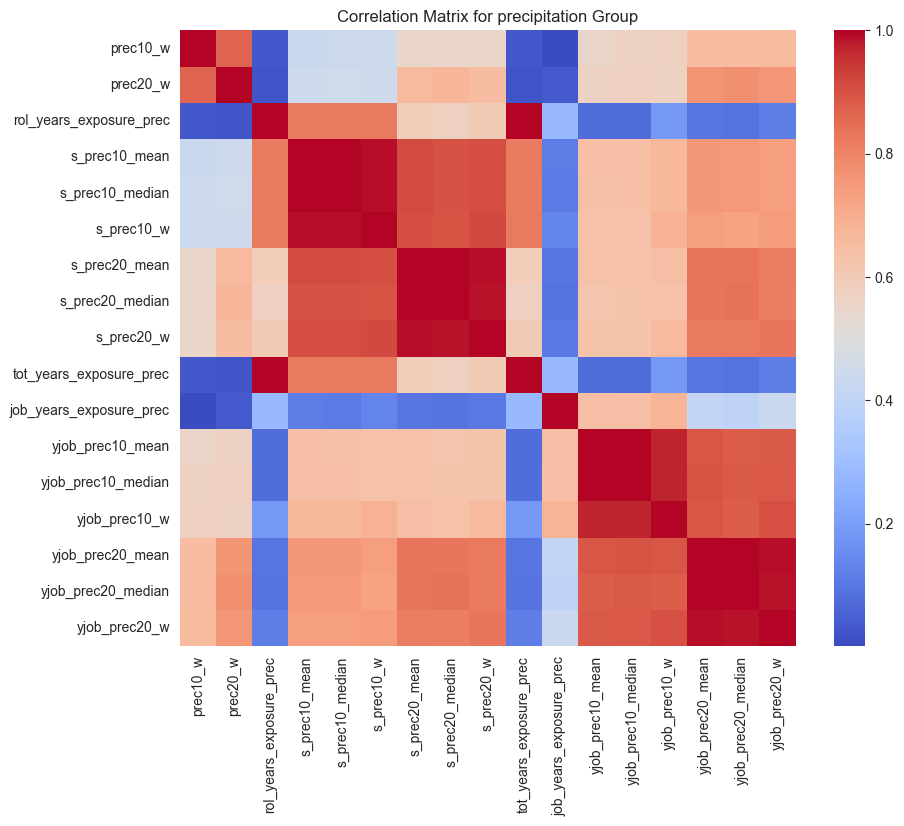

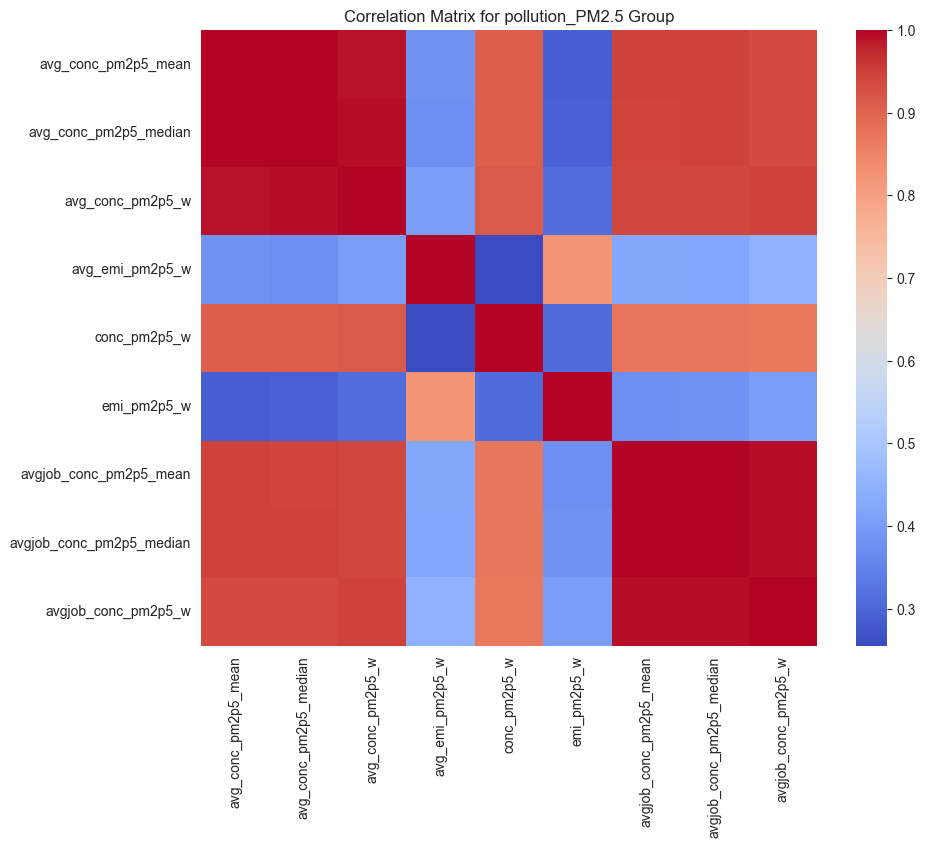

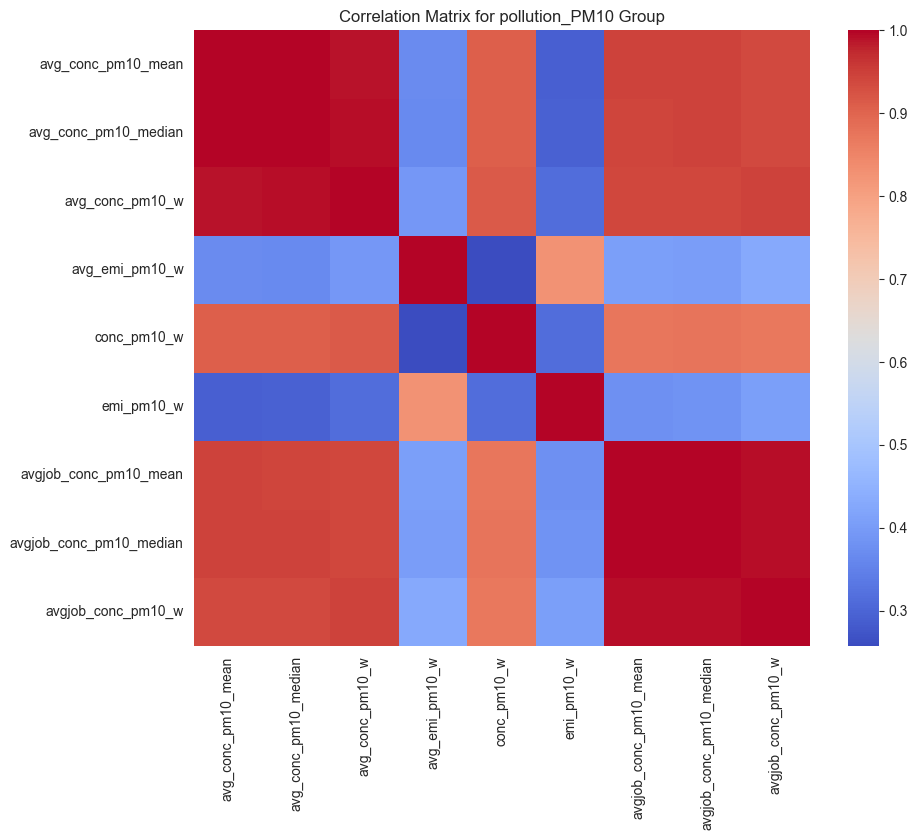

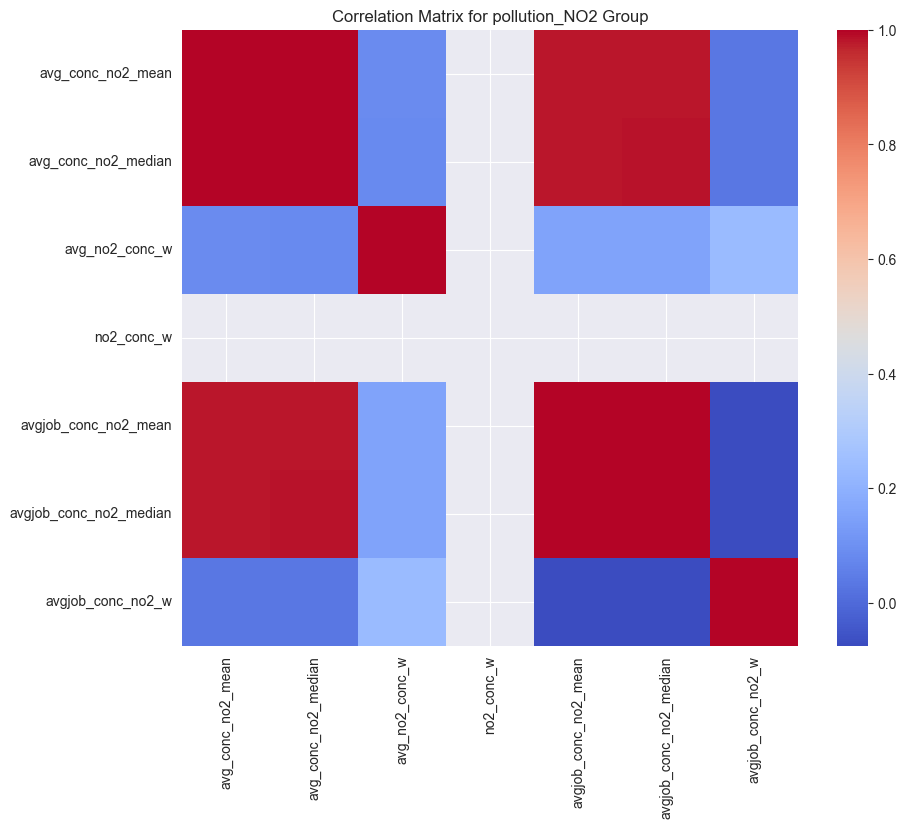

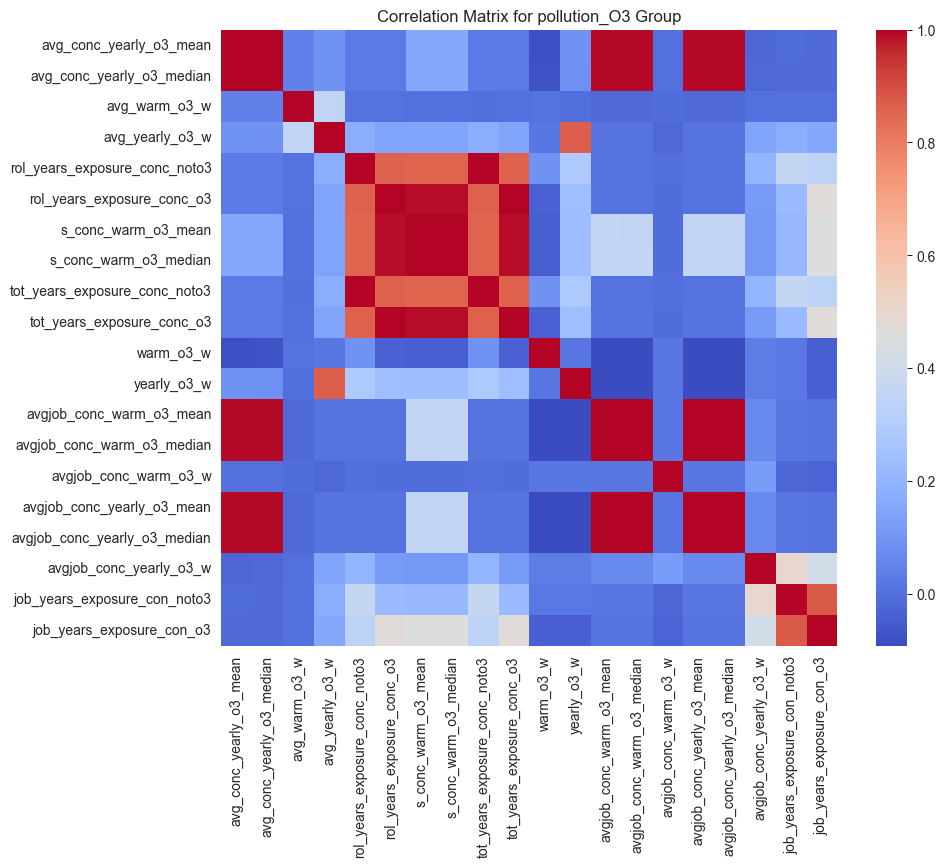

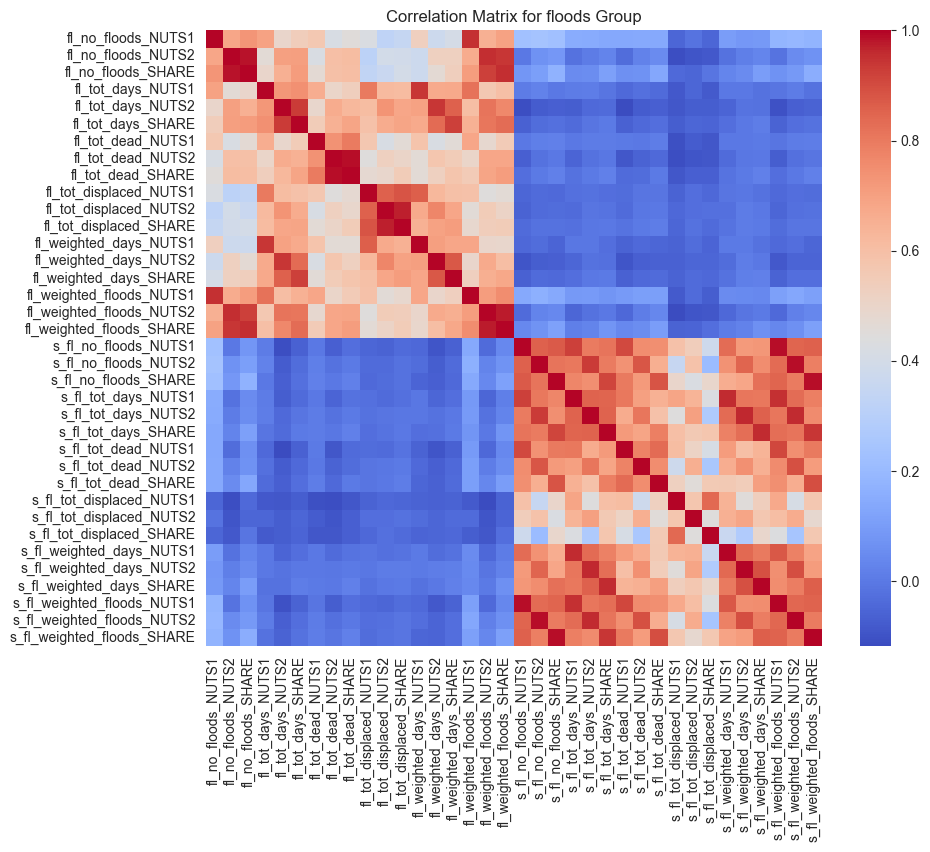

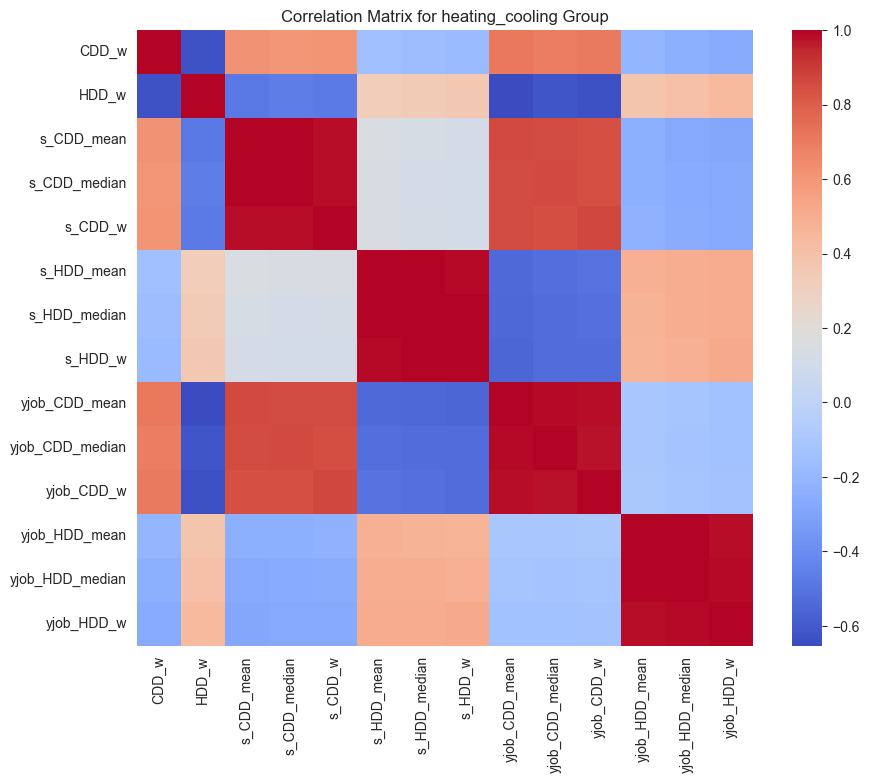

In [20]:
for group_name, features in feature_groups.items():
    # Filter the DataFrame to keep only the current group's features
    df_group = df_relevant[features]
    
    # Calculate the correlation matrix
    corr_matrix = df_group.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title(f'Correlation Matrix for {group_name} Group')
    plt.show()

Split the data

In [21]:
df_relevant = df_relevant.dropna(subset=['sphus'])

In [22]:
# Define features and target
X = df_relevant.drop('sphus', axis=1)  # Predictor variables
y = df_relevant['sphus']  # Outcome variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Normalize the data

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd


In [24]:
X_train_cleaned = X_train.dropna(axis=1, how='all')
X_test_cleaned = X_test.dropna(axis=1, how='all')

In [25]:
categorical_columns = X_train_cleaned.select_dtypes(include='object').columns
X_train_cleaned.loc[:, categorical_columns] = X_train_cleaned.loc[:, categorical_columns].fillna("missing")
X_test_cleaned.loc[:, categorical_columns] = X_test_cleaned.loc[:, categorical_columns].fillna("missing")

In [26]:
numeric_columns = X_train_cleaned.select_dtypes(include=np.number).columns
numeric_imputer = SimpleImputer(strategy='mean')

In [27]:
X_train_imputed = numeric_imputer.fit_transform(X_train_cleaned[numeric_columns])
X_test_imputed = numeric_imputer.transform(X_test_cleaned[numeric_columns])

In [28]:
scaler = StandardScaler() 

In [29]:
X_train_scaled = scaler.fit_transform(X_train_imputed)  # Fit and scale the training data
X_test_scaled = scaler.transform(X_test_imputed)  # Scale the testing data

In [30]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_columns)

In [31]:
print("Normalized DataFrames:")
print("X_train_scaled_df:")
print(X_train_scaled_df.head())
print("X_test_scaled_df:")
print(X_test_scaled_df.head())

Normalized DataFrames:
X_train_scaled_df:
       wave       age  eduyears_mod   age_partner  siblings_alive    ch001_  \
0 -1.009368  1.636769     -0.706918  1.713381e-15        0.000000 -0.956721   
1 -1.967597 -0.067976      0.050189  2.030108e-01        1.557585 -0.956721   
2 -0.530253 -0.814377     -0.202180  1.713381e-15        0.000000 -1.801237   
3  0.427976 -0.906526     -2.725869 -6.650823e-01        0.382433  1.576827   
4  0.907091 -0.620866     -0.202180 -3.516045e-01       -0.792720 -0.112205   

      ch021_mod  chronic_mod          casp   maxgrip  ...  yjob_tn_neg5_w  \
0 -5.416944e-02     0.572365 -1.449163e+00  0.000000  ...    4.423385e-16   
1 -1.096122e+00    -0.221141 -6.235310e-01 -0.493646  ...    4.423385e-16   
2 -1.542400e-16    -0.221141  1.192860e+00  0.506666  ...   -1.250891e+00   
3 -1.096122e+00    -1.014647 -1.281517e-01  0.000000  ...   -1.152007e+00   
4 -1.096122e+00    -0.221141 -1.173294e-15  0.324791  ...   -1.027958e+00   

   yjob_tx_25_27p5_m

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)

# Dictionary to store the most important features by group
best_features = {}

# Iterate over each feature group to identify the most important feature
for group_name, features in feature_groups.items():
    # Ensure the feature group is not empty and contains valid features
    if not features:
        continue
    
    # Select the current group's features from the scaled training data
    # Check if the feature group exists in the cleaned and scaled data
    valid_features = X_train_scaled_df.columns.intersection(features)

    if valid_features.empty:
        print(f"{group_name}: No valid features after data preparation.")
        continue

    # Train the Random Forest model on the selected features
    rf_model.fit(X_train_scaled_df[valid_features], y_train)

    # Get the feature importances and find the most important one
    importances = rf_model.feature_importances_
    most_important_feature = valid_features[np.argmax(importances)]
    best_features[group_name] = most_important_feature

    # Optionally, evaluate the model's performance on the test data
    predictions = rf_model.predict(X_test_scaled_df[valid_features])
    accuracy = accuracy_score(y_test, predictions)
    print(f"{group_name} - Most Important Feature: {most_important_feature}, Accuracy: {accuracy:.4f}")

# Output the best features from each group
print("Best Features by Group:", best_features)

temperature - Most Important Feature: s_tx_25_27p5_mean, Accuracy: 0.3623
radiation - Most Important Feature: avgjob_radiation_fall_median, Accuracy: 0.3542
precipitation - Most Important Feature: tot_years_exposure_prec, Accuracy: 0.3618
pollution_PM2.5 - Most Important Feature: avgjob_conc_pm2p5_w, Accuracy: 0.3511
pollution_PM10 - Most Important Feature: avgjob_conc_pm10_w, Accuracy: 0.3549
pollution_NO2 - Most Important Feature: avgjob_conc_no2_w, Accuracy: 0.3592
pollution_O3 - Most Important Feature: avgjob_conc_yearly_o3_w, Accuracy: 0.3579
floods - Most Important Feature: s_fl_tot_dead_SHARE, Accuracy: 0.3526
heating_cooling - Most Important Feature: s_HDD_w, Accuracy: 0.3603
Best Features by Group: {'temperature': 's_tx_25_27p5_mean', 'radiation': 'avgjob_radiation_fall_median', 'precipitation': 'tot_years_exposure_prec', 'pollution_PM2.5': 'avgjob_conc_pm2p5_w', 'pollution_PM10': 'avgjob_conc_pm10_w', 'pollution_NO2': 'avgjob_conc_no2_w', 'pollution_O3': 'avgjob_conc_yearly_o

In [33]:
# Step 1: Convert best_features values to a set for faster lookup
best_features_set = set(best_features.values())

# Step 2: Initialize a list to hold variables to drop
vars_to_drop = []

# Step 3: Identify variables to drop from each feature group
for group_name, features in feature_groups.items():
    vars_to_drop.extend([var for var in features if var not in best_features_set])

# Step 4: Drop these unwanted variables from the scaled DataFrames
X_train_selected = X_train_scaled_df.drop(columns=vars_to_drop, errors='ignore')
X_test_selected = X_test_scaled_df.drop(columns=vars_to_drop, errors='ignore')

# Step 5: Re-fit the transformation pipeline for consistent scaling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X_train_s_scaled = pipeline.fit_transform(X_train_selected)  # Fit and transform the selected training data
X_test_s_scaled = pipeline.transform(X_test_selected)  # Transform the selected test data

# Step 6: Output the shape of original and modified DataFrames to check consistency
print("Original X_train_scaled_df shape:", X_train_scaled_df.shape)
print("Modified X_train_s_scaled shape:", X_train_s_scaled.shape)

print("Original X_test_scaled_df shape:", X_test_scaled_df.shape)
print("Modified X_test_s_scaled shape:", X_test_s_scaled.shape)

Original X_train_scaled_df shape: (111284, 359)
Modified X_train_s_scaled shape: (111284, 101)
Original X_test_scaled_df shape: (27821, 359)
Modified X_test_s_scaled shape: (27821, 101)


In [34]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a new RandomForestClassifier
rf_top_grouped = RandomForestClassifier(random_state=42)

# Fit the RandomForest model on the selected and scaled training data
rf_top_grouped.fit(X_train_s_scaled, y_train)

# Get the parameters of the fitted RandomForestClassifier instance
rf_grouped_parameters = rf_top_grouped.get_params()

# Display each parameter and its value
print("Parameters of the RandomForestClassifier:")
for param, value in rf_grouped_parameters.items():
    print(f"The parameter '{param}' is set to {value}.")

Parameters of the RandomForestClassifier:
The parameter 'bootstrap' is set to True.
The parameter 'ccp_alpha' is set to 0.0.
The parameter 'class_weight' is set to None.
The parameter 'criterion' is set to gini.
The parameter 'max_depth' is set to None.
The parameter 'max_features' is set to sqrt.
The parameter 'max_leaf_nodes' is set to None.
The parameter 'max_samples' is set to None.
The parameter 'min_impurity_decrease' is set to 0.0.
The parameter 'min_samples_leaf' is set to 1.
The parameter 'min_samples_split' is set to 2.
The parameter 'min_weight_fraction_leaf' is set to 0.0.
The parameter 'monotonic_cst' is set to None.
The parameter 'n_estimators' is set to 100.
The parameter 'n_jobs' is set to None.
The parameter 'oob_score' is set to False.
The parameter 'random_state' is set to 42.
The parameter 'verbose' is set to 0.
The parameter 'warm_start' is set to False.


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_top_grouped = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
}

cv_rf = GridSearchCV(estimator=rf_top_grouped, param_grid=param_grid, cv=5, n_jobs=1)  # No parallel processing

cv_rf.fit(X_train_s_scaled, y_train)

print("Best parameters:", cv_rf.best_params_)

KeyboardInterrupt: 

In [37]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [10, 20],  # Simplified for speed
    'max_depth': [None, 10],   # Reduced options
    'min_samples_split': [2, 5],  # Default and one variation
}

rf = RandomForestClassifier(random_state=42)

cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=1)  

try:
    cv_rf.fit(X_train_s_scaled, y_train)  
except Exception as e:
    print("Error during GridSearchCV fitting:", e)  

try:
    y_pred = cv_rf.predict(X_test_s_scaled) 
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
except Exception as e:
    print("Error during prediction:", e)  

Accuracy: 0.4797095719061141
Classification Report:
               precision    recall  f1-score   support

1. Excellent       0.67      0.00      0.00      1696
2. Very good       0.44      0.08      0.14      4455
     3. Good       0.45      0.77      0.57      9739
     4. Fair       0.49      0.45      0.47      8037
     5. Poor       0.64      0.46      0.54      3894

    accuracy                           0.48     27821
   macro avg       0.54      0.35      0.34     27821
weighted avg       0.50      0.48      0.43     27821


Initial Random Forest Fitting and Feature Selection

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the limited Random Forest model
rf_limitted = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)

# Feature counts to evaluate
feature_counts = [50, 100, 150, 200, X_train_s_scaled.shape[1]]  # Evaluate different feature counts

# Dictionary to store the average accuracy for each feature count
results = {}

# Iterate over the feature counts
for count in feature_counts:
    # Select the first N features
    X_train_subset = X_train_s_scaled[:, :count]
    X_test_subset = X_test_s_scaled[:, :count]

    # Re-fit the imputation and scaling pipeline
    X_train_scaled_subset = pipeline.fit_transform(X_train_subset)  # Re-fit for each subset
    X_test_scaled_subset = pipeline.transform(X_test_subset)

    # Evaluate the model with cross-validation
    scores = cross_val_score(rf_limitted, X_train_scaled_subset, y_train, cv=5, scoring='accuracy')

    # Store the average accuracy for this feature count
    results[count] = np.mean(scores)
    print(f"Average accuracy with top {count} features: {results[count]:.4f}")

Average accuracy with top 50 features: 0.4657
Average accuracy with top 100 features: 0.4684
Average accuracy with top 150 features: 0.4626
Average accuracy with top 200 features: 0.4626
Average accuracy with top 101 features: 0.4626


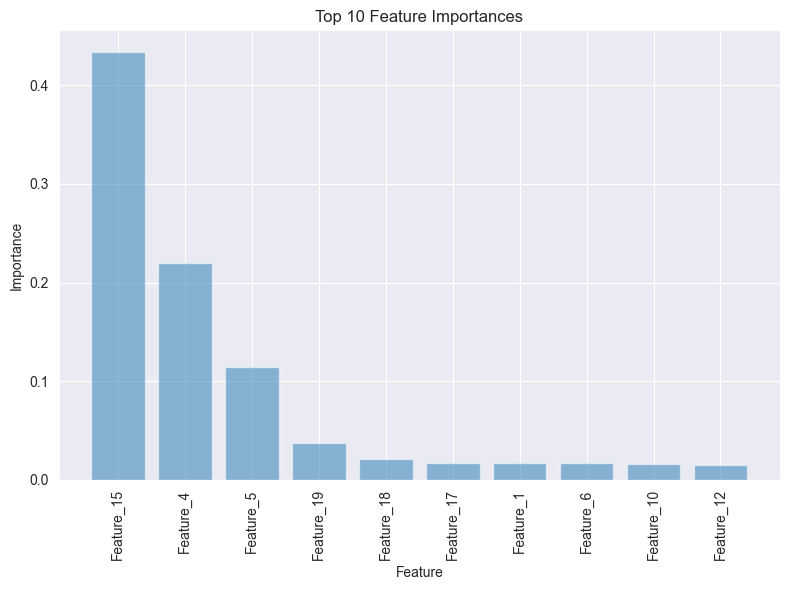

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

# Generate sample data with 20 features
X, y = make_classification(n_samples=500, n_features=20, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with imputation and scaling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Fit and transform the training data
X_train_cleaned = pipeline.fit_transform(X_train)

# Transform the testing data
X_test_cleaned = pipeline.transform(X_test)

# Create feature names based on the number of columns
num_features = X_train_cleaned.shape[1]
feature_names = [f'Feature_{i}' for i in range(num_features)]

# Convert cleaned data to DataFrames with feature names
X_train_df = pd.DataFrame(X_train_cleaned, columns=feature_names)
X_test_df = pd.DataFrame(X_test_cleaned, columns=feature_names)

# Fit the Random Forest model on the cleaned training data
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)
rf.fit(X_train_df, y_train)

# Get feature importances and sort them
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1][:10]  # Top 10 features

# Plot the top 10 feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(10), feature_importances[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(10), [feature_names[i] for i in sorted_indices], rotation=90, fontsize=10)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

ROC curve